In [2]:
# Import main module
from __future__ import division
from dateutil.relativedelta import relativedelta
import scipy.integrate as integrate
import getData
import datetime
import csv
import os

# Imports useful for graphics
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("whitegrid")
seaborn.despine()
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

In [3]:
# Input parameters
year = 2011
nbMonth = 12*5

categories=['time', 'solar', 'wind', 'load']
result = []
for index in range(0, nbMonth):
    result.append({})
    for category in categories:
        result[-1][category] = []

folder = os.path.join(os.getcwd(), 'csv_result/')
pathList = []
fileDate = datetime.datetime(year, 1, 1, 0, 0, 0)
for index in range(0, nbMonth):
    pathList.append(folder + str(fileDate.year) + '-' + str(fileDate.month) + '.csv')
    fileDate = fileDate + relativedelta(months=1)
    
for index, path in enumerate(pathList):
    with open(path) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            for category in categories:
                if not category == 'time':
                    result[index][category].append(float(row[category]))
                else:
                    result[index][category].append(datetime.datetime.strptime(row[category], '%Y-%m-%d %H:%M:%S'))

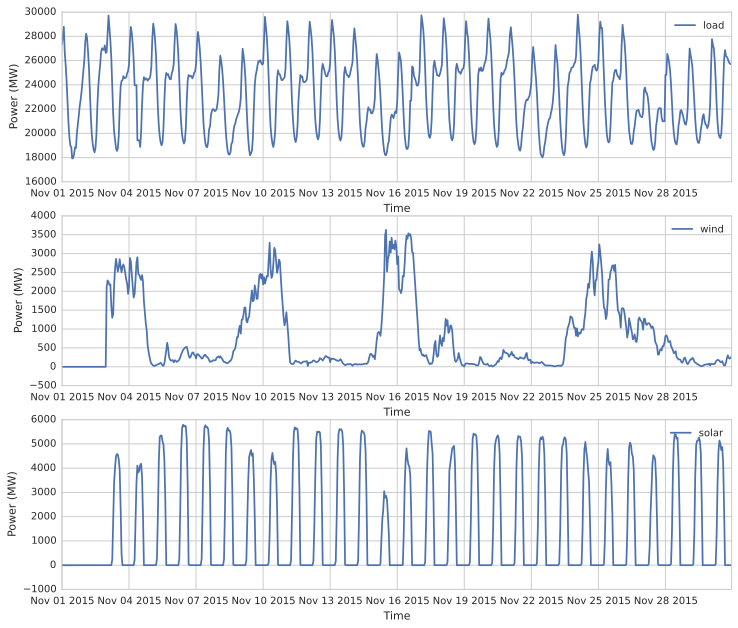

In [25]:
# Plot data
monthIndex = 10

plt.figure(figsize=(12, 14), dpi=80)
nbPlot = 410
for category in result[monthIndex]:
    if not category == 'time':
        nbPlot += 1
        plt.subplot(nbPlot)
        plt.plot(result[monthIndex]['time'], result[monthIndex][category], label=category)
        plt.xlabel('Time')
        plt.ylabel('Power (MW)')
        plt.legend()
plt.show()

In [4]:
# Fix missing data
for i in range(0, len(result)):
    for category in categories:
        if not category == 'time':
            for index in range(0, len(result[i][category])):
                # If one of the value is -1
                if result[i][category][index] < 0:
                    # Get the hour of the day
                    hour = result[i]['time'][index].hour
                    start = index - hour   # 00:00:00 of this day
                    end = start + 23  # 23:00:00 of this day
                    # Replace the whole day by the previous one
                    if start > 23:
                        result[i][category][start:end+1] = result[i][category][start-24:end+1-24]
                    else:
                        a = len(result[i]['time']) - 24
                        b = len(result[i]['time'])
                        result[i][category][0:24] = result[i][category][a:b]
                    print('The ' + str(result[i]['time'][index]) + ' has been replaced by the previous day')


The 2011-01-29 01:00:00 has been replaced by the previous day
The 2011-03-12 00:00:00 has been replaced by the previous day
The 2011-03-13 00:00:00 has been replaced by the previous day
The 2011-03-14 00:00:00 has been replaced by the previous day
The 2011-03-12 00:00:00 has been replaced by the previous day
The 2011-03-13 00:00:00 has been replaced by the previous day
The 2011-03-14 00:00:00 has been replaced by the previous day
The 2011-06-30 00:00:00 has been replaced by the previous day
The 2011-07-16 00:00:00 has been replaced by the previous day
The 2011-07-16 00:00:00 has been replaced by the previous day
The 2011-11-05 00:00:00 has been replaced by the previous day
The 2011-11-06 00:00:00 has been replaced by the previous day
The 2011-11-07 00:00:00 has been replaced by the previous day
The 2011-11-05 00:00:00 has been replaced by the previous day
The 2011-11-06 00:00:00 has been replaced by the previous day
The 2011-11-07 00:00:00 has been replaced by the previous day
The 2012

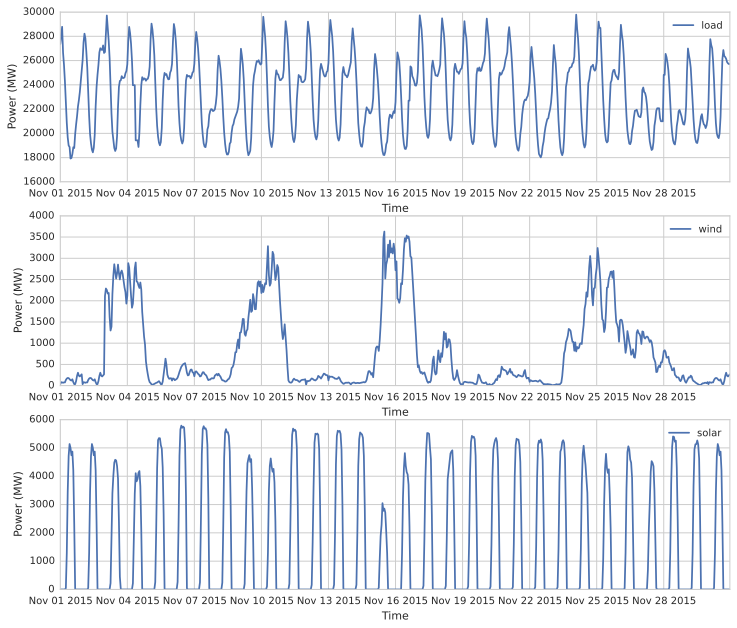

In [27]:
# Plot data
monthIndex = 10

plt.figure(figsize=(12, 14), dpi=80)
nbPlot = 410
for category in result[monthIndex]:
    if not category == 'time':
        nbPlot += 1
        plt.subplot(nbPlot)
        plt.plot(result[monthIndex]['time'], result[monthIndex][category], label=category)
        plt.xlabel('Time')
        plt.ylabel('Power (MW)')
        plt.legend()
plt.show()

In [5]:
# Analysis
resultCategories = ['year', 'month', 'loadE', 'solarE', 'windE', 'loadPmax', 'solarPmax', 'windPmax', 'netLoadmin']
parallel = {}
for resultCategory in resultCategories:
    parallel[resultCategory] = []

for index in range(0, len(result)):
    for resultCategory in resultCategories:
        
        # Energy
        if resultCategory == 'loadE' or resultCategory == 'solarE' or resultCategory == 'windE':
            if resultCategory == 'loadE':
                category = 'load'
            elif resultCategory == 'solarE':
                category = 'solar'
            else:
                category = 'wind'
            # Get the integral (MWh)
            parallel[resultCategory].append(integrate.cumtrapz(y=result[index][category], dx=1, initial=0.0)[-1])
        
        # Average power max per day
        if resultCategory == 'loadPmax' or resultCategory == 'solarPmax' or resultCategory == 'windPmax':
            if resultCategory == 'loadPmax':
                category = 'load'
            elif resultCategory == 'solarPmax':
                category = 'solar'
            else:
                category = 'wind'
            now = result[index]['time'][0]
            maximum = []
            tempMax = 0
            for time, value in zip(result[index]['time'], result[index][category]):
                if time.day != now.day:
                    maximum.append(tempMax)
                    now = time
                    tempMax = 0
                if value > tempMax:
                    tempMax = value
            parallel[resultCategory].append(sum(maximum)/len(maximum))
        
        # Average min net load per day
        if resultCategory == 'netLoadmin':
            now = result[index]['time'][0]
            minimum = []
            tempMin = 9999999999999
            for i, time in enumerate(result[index]['time']):
                value = result[index]['load'][i] - result[index]['solar'][i] - result[index]['wind'][i]
                if time.day != now.day:
                    minimum.append(tempMin)
                    now = time
                    tempMin = 9999999999999
                if value < tempMin:
                    tempMin = value
            parallel[resultCategory].append(sum(minimum)/len(minimum))
        
        # Date
        if resultCategory == 'year':
            parallel[resultCategory].append(result[index]['time'][0].year)   
        if resultCategory == 'month':
            parallel[resultCategory].append(result[index]['time'][0].month)                
                


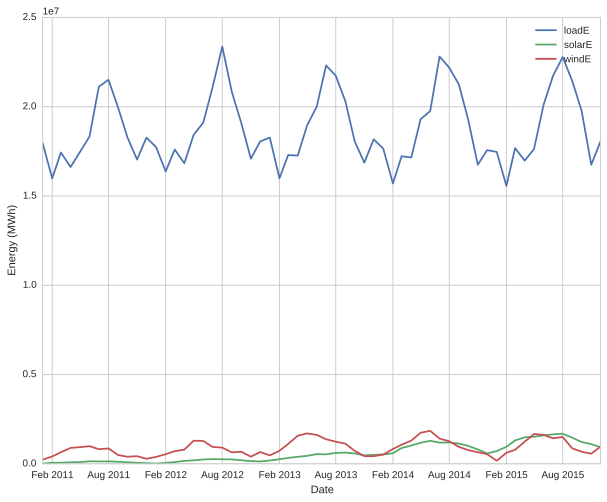

In [6]:
# List of dates to plot results
dateList = []
for year, month in zip(parallel['year'], parallel['month']):
    dateList.append(datetime.datetime(year, month, 1, 0, 0, 0))

# Plot energy
plt.figure(figsize=(10, 8), dpi=80)
for category in ['loadE', 'solarE', 'windE']:
    plt.plot(dateList, parallel[category], label=category)
    plt.xlabel('Date')
    plt.ylabel('Energy (MWh)')
    plt.legend()
plt.show()

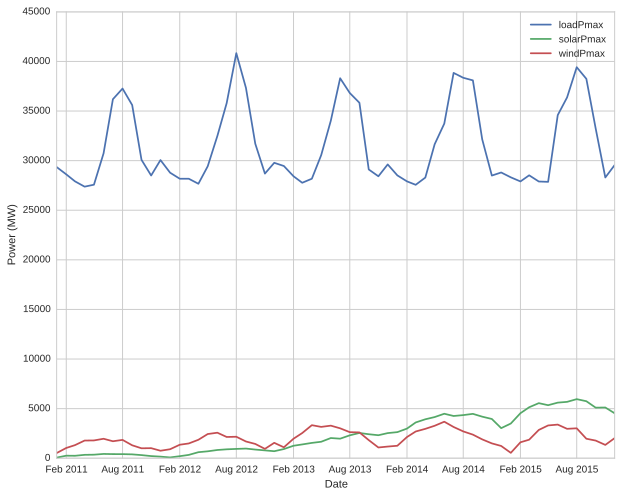

In [7]:
# Plot max power
plt.figure(figsize=(10, 8), dpi=80)
for category in ['loadPmax', 'solarPmax', 'windPmax']:
    plt.plot(dateList, parallel[category], label=category)
    plt.xlabel('Date')
    plt.ylabel('Power (MW)')
    plt.legend()
plt.show()

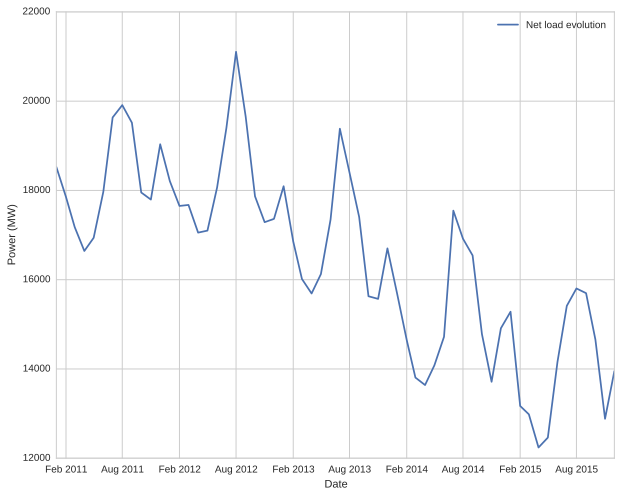

In [8]:
# Plot net load min
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(dateList, parallel['netLoadmin'], label='Net load evolution')
plt.xlabel('Date')
plt.ylabel('Power (MW)')
plt.legend()
plt.show()

In [9]:
# Write the results in a csv file
cat = ['year', 'month', 'loadE', 'solarE', 'windE', 'loadPmax', 'solarPmax', 'windPmax', 'netLoadmin']
with open('parallel.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', lineterminator='\n')

    # Make the header
    row = []
    for category in cat:
        row.append(category)
    writer.writerow(row)

    # Fill the data
    for index in range(0, len(parallel['year'])):
        row = []
        for category in cat:
            # Build the row of values (location, time, ...)
            row.append(parallel[category][index])
        writer.writerow(row)